In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import sklearn.metrics as metric
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [138]:
fpkm = pd.read_csv("../datasets/datasets_processed/fpkm/toden_fpkm.txt", sep="\t", index_col=0)
tpm = pd.read_csv("../datasets/datasets_processed/tpm/toden_tpm.txt", sep="\t", index_col=0)
raw_count = pd.read_csv("../datasets/datasets_raw/toden/toden_counts.txt", sep="\t")
meta = pd.read_excel("../datasets/datasets_raw/toden/toden_metadata.xlsx")

In [65]:
# Normalization: standard scale

def PreProcessNumerical(df, dfFit, columnNames):
    scaler = StandardScaler()
    scaler.fit(dfFit[columnNames])
    df[columnNames] = scaler.transform(df[columnNames])
    return df

In [139]:
# Normalize raw count data
preCount = raw_count.copy()
norCount = PreProcessNumerical(preCount, preCount, preCount.columns)

In [140]:
# Convert categorical variable ['Apoe.status','apoe_carrier','apoe_dose']
share_feat = ['Apoe.status','apoe_carrier','apoe_dose']
status_dic = {'None': 0, 'E2/E3': 1, 'E2/E4': 2, 'E3/E3': 3, 'E3/E4': 4, 'E4/E4': 5}
carrier_dic = {'None': 0, 'no_apoe4': 0, 'apoe4': 1}
dose_dic = {'apoe4': 1, 'None': 0, 'apoe44': 2, 'no_apoe4': 0}
com_dic = [status_dic, carrier_dic, dose_dic]

meta_feat = meta[share_feat].copy()
for i in range(len(share_feat)):
    meta_feat[share_feat[i]] = [com_dic[i][x] for x in meta_feat[share_feat[i]]]

In [144]:
tab1 = pd.read_excel("../abb1654_data_file_s1.xlsx", sheet_name="Upregulated genes", header=1)
tab2 = pd.read_excel("../abb1654_data_file_s1.xlsx", sheet_name="Downregulated genes", header=1)
select_gene = list(set(list(tab1['ID'])+list(tab2['ID'])))

In [153]:
# Prepare training data (x)
# df1: standard-scaled raw count
# df2: standarad-scaled raw count + share_feat(apoe status, carrier, dose)
# df3: FPKM, df4: FPKM + APOE, df5: TPM, df6: TPM + APOE
df1 = norCount.T
df2 = df1.copy()[list(set(df1.columns) & set(select_gene))]
df3 = df2.copy()
df4 = fpkm.copy()
df5 = fpkm.copy()[list(set(df4.columns) & set(select_gene))]
df6 = df5.copy()
df7 = tpm.copy()
df8 = tpm.copy()[list(set(df7.columns) & set(select_gene))]
df9 = df8.copy()
for i in meta_feat.columns:
    df3[i] = meta_feat[i].values
    df6[i] = meta_feat[i].values
    df9[i] = meta_feat[i].values

train_input=['normalized count', 'select-gene normalized count', 'select-gene normalized count+apoe', 'FPKM', 'select-gene FPKM',
             'select-gene FPKM+apoe', 'TPM', 'select-gene TPM', 'select-gene TPM+apoe']
train_data = [df1, df2, df3, df4, df5, df6, df7, df8, df9]

In [143]:
# extract y

y = meta['Disease']
ma = {'NCI': 0, 'AD': 1}
for i in range(len(y)):
    y.iloc[i] = ma[y.iloc[i]]

/var/folders/z0/gtt3z07d02n_lrzk3xy2qv0w0000gn/T/ipykernel_22700/4007269279.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.iloc[i] = ma[y.iloc[i]]


In [154]:
# Decision Tree

for i in range(len(train_data)):
    dTrain = train_data[i]
    accuracy = []
    roc_score = []
    f1_score = []
    mcc_score = []
    recall = []
    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True,random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,]
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(XTrain, list(yTrain))
        pred = clf.predict(XVal)
        
        accuracy.append(metric.accuracy_score(list(yVal), clf.predict(XVal)))
        roc_score.append(metric.roc_auc_score(list(yVal), clf.predict_proba(XVal)[:,1]))
        f1_score.append(metric.f1_score(list(yVal), clf.predict(XVal)))
        mcc_score.append(metric.matthews_corrcoef(list(yVal), clf.predict(XVal)))
        recall.append(metric.recall_score(list(yVal), clf.predict(XVal)))
    print(f"Train: {train_input[i]}, mean val accuracy: {sum(accuracy)/len(accuracy)}")    
    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")
    print(f"Train: {train_input[i]}, mean val F1: {sum(f1_score)/len(f1_score)}")
    print(f"Train: {train_input[i]}, mean val MCC: {sum(mcc_score)/len(mcc_score)}")
    print(f"Train: {train_input[i]}, mean val Recall: {sum(recall)/len(recall)}\n")

Train: normalized count, mean val accuracy: 0.7006784260515604
Train: normalized count, mean val AUC: 0.6966711160809892
Train: normalized count, mean val F1: 0.7059189902441894
Train: normalized count, mean val MCC: 0.3940075425486434
Train: normalized count, mean val Recall: 0.7396799514602241

Train: select-gene normalized count, mean val accuracy: 0.6886928991406602
Train: select-gene normalized count, mean val AUC: 0.6810443641738223
Train: select-gene normalized count, mean val F1: 0.6963333948250516
Train: select-gene normalized count, mean val MCC: 0.3663750517594325
Train: select-gene normalized count, mean val Recall: 0.7233606581722059

Train: select-gene normalized count+apoe, mean val accuracy: 0.6915875169606512
Train: select-gene normalized count+apoe, mean val AUC: 0.6814329065334637
Train: select-gene normalized count+apoe, mean val F1: 0.7120590837366485
Train: select-gene normalized count+apoe, mean val MCC: 0.36910858641237737
Train: select-gene normalized count+apo

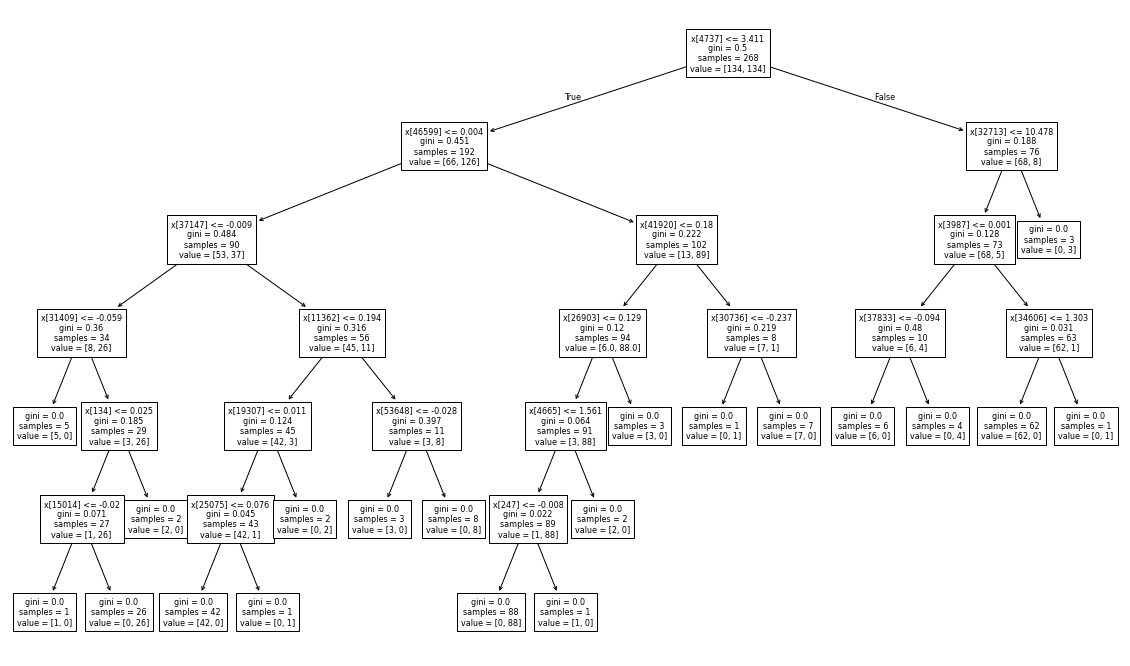

In [12]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [155]:
# GaussianNB approach
for i in range(len(train_data)):
    dTrain = train_data[i]
    accuracy = []
    roc_score = []
    f1_score = []
    mcc_score = []
    recall = []
    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True,random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,]
        gnb = GaussianNB()
        gnb.fit(XTrain, yTrain.astype(int))
        pred = gnb.predict(XVal)
        
        accuracy.append(metric.accuracy_score(list(yVal), gnb.predict(XVal)))
        roc_score.append(metric.roc_auc_score(list(yVal), gnb.predict_proba(XVal)[:,1]))
        f1_score.append(metric.f1_score(list(yVal), gnb.predict(XVal)))
        mcc_score.append(metric.matthews_corrcoef(list(yVal), gnb.predict(XVal)))
        recall.append(metric.recall_score(list(yVal), gnb.predict(XVal)))
    print(f"Train: {train_input[i]}, mean val Accuracy: {sum(accuracy)/len(accuracy)}")    
    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")
    print(f"Train: {train_input[i]}, mean val F1: {sum(f1_score)/len(f1_score)}")
    print(f"Train: {train_input[i]}, mean val MCC: {sum(mcc_score)/len(mcc_score)}")
    print(f"Train: {train_input[i]}, mean val Recall: {sum(recall)/len(recall)}\n")

Train: normalized count, mean val Accuracy: 0.6350067842605156
Train: normalized count, mean val AUC: 0.6396282619640521
Train: normalized count, mean val F1: 0.5693703875824891
Train: normalized count, mean val MCC: 0.29316902684469115
Train: normalized count, mean val Recall: 0.47804551028287995

Train: select-gene normalized count, mean val Accuracy: 0.5805970149253732
Train: select-gene normalized count, mean val AUC: 0.6622744148752886
Train: select-gene normalized count, mean val F1: 0.3577439882711136
Train: select-gene normalized count, mean val MCC: 0.1597257591499321
Train: select-gene normalized count, mean val Recall: 0.2779627295986558

Train: select-gene normalized count+apoe, mean val Accuracy: 0.5805970149253732
Train: select-gene normalized count+apoe, mean val AUC: 0.6624559030785553
Train: select-gene normalized count+apoe, mean val F1: 0.3577439882711136
Train: select-gene normalized count+apoe, mean val MCC: 0.1597257591499321
Train: select-gene normalized count+ap

In [156]:
# Random Forest approach
for i in range(len(train_data)):
    dTrain = train_data[i]
    accuracy = []
    roc_score = []
    f1_score = []
    mcc_score = []
    recall = []
    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True,random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,]
        rfc = RandomForestClassifier()
        rfc.fit(XTrain, yTrain.astype(int))
        pred = rfc.predict(XVal)
        
        accuracy.append(metric.accuracy_score(list(yVal), rfc.predict(XVal)))
        roc_score.append(metric.roc_auc_score(list(yVal), rfc.predict_proba(XVal)[:,1]))
        f1_score.append(metric.f1_score(list(yVal), rfc.predict(XVal)))
        mcc_score.append(metric.matthews_corrcoef(list(yVal), rfc.predict(XVal)))
        recall.append(metric.recall_score(list(yVal), rfc.predict(XVal)))
    print(f"Train: {train_input[i]}, mean val Accuracy: {sum(accuracy)/len(accuracy)}")    
    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")
    print(f"Train: {train_input[i]}, mean val F1: {sum(f1_score)/len(f1_score)}")
    print(f"Train: {train_input[i]}, mean val MCC: {sum(mcc_score)/len(mcc_score)}")
    print(f"Train: {train_input[i]}, mean val Recall: {sum(recall)/len(recall)}\n")

Train: normalized count, mean val Accuracy: 0.7786521935775668
Train: normalized count, mean val AUC: 0.8477808796248842
Train: normalized count, mean val F1: 0.7792236770000075
Train: normalized count, mean val MCC: 0.5521204262159397
Train: normalized count, mean val Recall: 0.7788003377417974

Train: select-gene normalized count, mean val Accuracy: 0.7845771144278607
Train: select-gene normalized count, mean val AUC: 0.8426131854574063
Train: select-gene normalized count, mean val F1: 0.7793363042180562
Train: select-gene normalized count, mean val MCC: 0.5673931097741924
Train: select-gene normalized count, mean val Recall: 0.7633124578353127

Train: select-gene normalized count+apoe, mean val Accuracy: 0.7845771144278607
Train: select-gene normalized count+apoe, mean val AUC: 0.8479997125376034
Train: select-gene normalized count+apoe, mean val F1: 0.7813166000128092
Train: select-gene normalized count+apoe, mean val MCC: 0.5641521668058515
Train: select-gene normalized count+apoe